# Create JsonLine files from CSV ground truth


This script will create two labeled datasets: <dataset_name>_training and <dataset_name>_test

1. split training and test labeled datapoints
2. create json-line files for training and test
3. upload json-line files to default workspace blobstore, under fhl/datasets/<dataset_name>/label folder
4. register labeled datasets

In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split


In [30]:
datastore_name = 'workspaceblobstore'
dataset_name = 'NoWindow'
balanced_dataset_name = 'Balanced_NoWindow'

In [22]:
# read ground truth from csv file
raw_df = pd.read_csv('Users/shansl/fhl/stage_2_detailed_class_info.csv')
dedup_df = raw_df[ (raw_df['patientId'].duplicated(keep='first') == False)]

cwd:/mnt/batch/tasks/shared/LS_root/mounts/clusters/shanslvm/code


18036 new training size


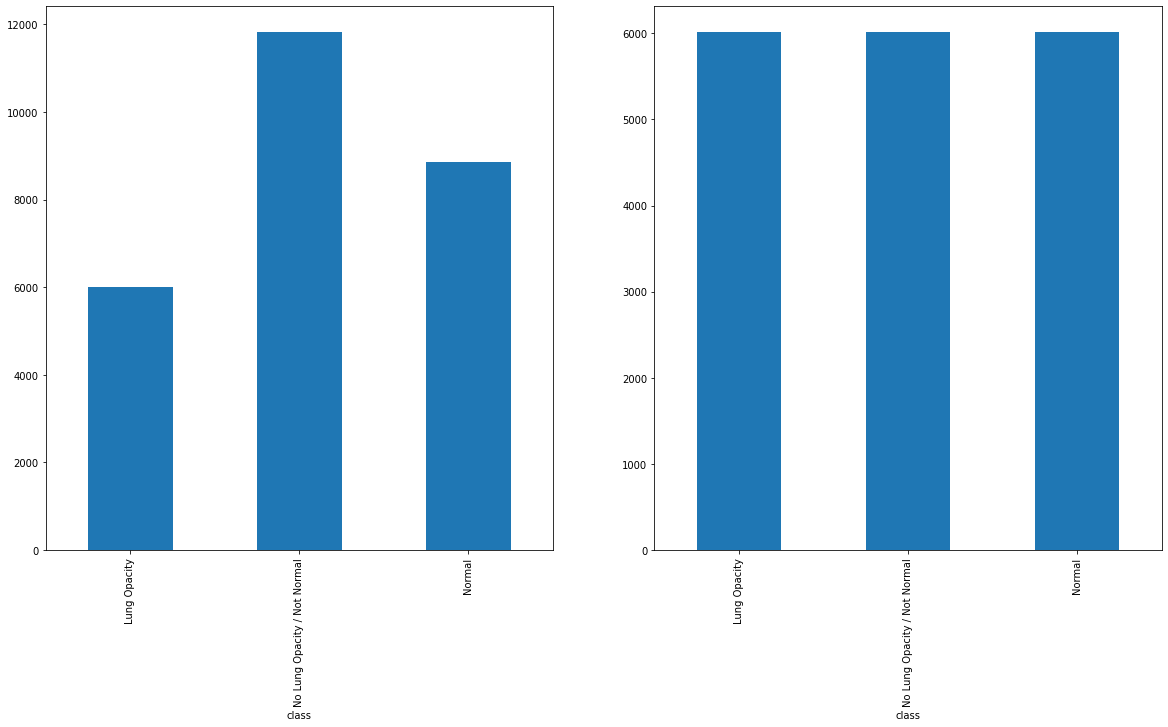

In [31]:
# balance dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
dedup_df.groupby('class').size().plot.bar(ax=ax1)

min_samples_count = min(dedup_df.groupby('class').size())

balanced_dedup_df = dedup_df.groupby('class').\
    apply(lambda x: x.sample(min_samples_count)).\
    reset_index(drop=True)
balanced_dedup_df.groupby('class').size().plot.bar(ax=ax2) 

print(balanced_dedup_df.shape[0], 'new dataset size')

In [37]:
# split into train and test
train, test = train_test_split(balanced_dedup_df, test_size = 0.2, random_state = 2021)
print(train.shape[0], 'new training size')
print(test.shape[0], 'new test size')

14428 new training size
3608 new test size


In [40]:
# Create Multi-Class JasonLine Objects
def create_jsonline_objects(datastore_name: str, dataset_name: str, df: pd.DataFrame):
    jsonline_obj = []
    for _, row in df.iterrows():
        obj = {}
        obj['image_url'] = 'AmlDatastore://' + datastore_name + '/fhl/datasets/' + dataset_name + '/image/' + row['patientId'] + '.png'
        obj['label'] = row['class']
        obj['label_confidence'] = 1.0
        jsonline_obj.append(obj)
    return jsonline_obj

In [41]:
import os
import json
def save_jsonline_file(objects: list, file_name: str):
    base_path = os.path.dirname(file_name)
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    with open(file_name, 'w') as jf:
        for obj in objects:
            jf.write('{}\n'.format(json.dumps(obj)))

In [43]:
# Generate jsonline files, which can be registered as labeled dataset
training_label_folder = os.path.abspath(os.path.join(os.path.curdir, 'training_label'))
test_label_folder = os.path.abspath(os.path.join(os.path.curdir, 'test_label'))

train_obj = create_jsonline_objects(datastore_name, balanced_dataset_name, train)
save_jsonline_file(train_obj, os.path.join(training_label_folder, 'labeleddatapoints_training.jsonl'))

test_obj = create_jsonline_objects(datastore_name, balanced_dataset_name, test)
save_jsonline_file(test_obj, os.path.join(test_label_folder, 'labeleddatapoints_test.jsonl'))

In [44]:
import azureml.core
from azureml.core import Workspace
# Load workspace
ws = Workspace.from_config()
ds = ws.datastores['workspaceblobstore']
ds.upload(src_dir = training_label_folder, target_path= '/fhl/datasets/' + balanced_dataset_name + '/label/', overwrite= True)
ds.upload(src_dir = './test_label', target_path= '/fhl/datasets/' + balanced_dataset_name + '/label/', overwrite= True)


Uploading an estimated of 1 files
Uploading /mnt/batch/tasks/shared/LS_root/mounts/clusters/shanslvm/code/training_label/labeleddatapoints_training.jsonl
Uploaded /mnt/batch/tasks/shared/LS_root/mounts/clusters/shanslvm/code/training_label/labeleddatapoints_training.jsonl, 1 files out of an estimated total of 1
Uploaded 1 files
Uploading an estimated of 1 files
Uploading ./test_label/labeleddatapoints_test.jsonl
Uploaded ./test_label/labeleddatapoints_test.jsonl, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_41aa191f16ad42d88feb67ddc6e83d80

In [45]:
# Create/register labeled dataset for training and test(inference)
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask

tags = {}
tags['labelingCreatedBy'] = "Guess"
tags['labelingProjectType'] = 'Image Classification Multi-class'
tags['SourceDatastoreName'] = 'workspaceblobstore'
tags['SourceRelativePath'] = 'fhl/datasets/' + balanced_dataset_name + '/image/'
tags['labelingLabelName'] = '["Lung Opacity","No Lung Opacity / Not Normal","Normal"]'

training_dataset = _LabeledDatasetFactory.from_json_lines(task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('fhl/datasets/' + balanced_dataset_name + '/label/labeleddatapoints_training.jsonl'))
training_dataset.register(ws, balanced_dataset_name + '_training', tags= tags)

test_dataset = _LabeledDatasetFactory.from_json_lines(task=LabeledDatasetTask.IMAGE_CLASSIFICATION, path=ds.path('fhl/datasets/' + balanced_dataset_name + '/label/labeleddatapoints_test.jsonl'))
test_dataset.register(ws, balanced_dataset_name + '_test', tags= tags)

{
  "source": [
    "('workspaceblobstore', 'fhl/datasets/Balanced_NoWindow/label/labeleddatapoints_test.jsonl')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseJsonLines",
    "ExpressionAddColumn",
    "DropColumns",
    "DropColumns",
    "RenameColumns",
    "DropColumns"
  ],
  "registration": {
    "id": "2d8d0910-90ce-4c02-81d4-55abb2f8778c",
    "name": "Balanced_NoWindow_test",
    "version": 1,
    "tags": {
      "labelingCreatedBy": "Guess",
      "labelingProjectType": "Image Classification Multi-class",
      "SourceDatastoreName": "workspaceblobstore",
      "SourceRelativePath": "fhl/datasets/Balanced_NoWindow/image/",
      "labelingLabelName": "[\"Lung Opacity\",\"No Lung Opacity / Not Normal\",\"Normal\"]"
    },
    "workspace": "Workspace.create(name='dicommodel', subscription_id='f375b912-331c-4fc5-8e9f-2d7205e3e036', resource_group='dicom-model-rg')"
  }
}